In [1]:
import os
import glob
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
from pathlib import Path as p
from sklearn.metrics import jaccard_score as js

In [2]:
#only variable that needs to be changed
#varibles = derivatives, template
work_dir = p('/media/Data/GoogleDriveNtust/dissertation_01/workFinal/workDir')
template = p('/media/Data/GoogleDriveNtust/dissertation_01/workFinal/templates/MNI152_T1_1mm_brain.nii')

In [3]:
derivatives = p(f'{work_dir}/test_dataset/derivatives')
#variables = pipeline1, jSResultsSubcortical, subCorticalImages, totalArray
pipeline0 = p(f'{derivatives}/pipeline_0')
pipeline1 = p(f'{derivatives}/pipeline_1')

os.chdir(derivatives)
os.chdir('../..')
results = os.getcwd()
outputResults = p(f'{results}/registration_results')
jSResultsFull = p(f'{outputResults}/jaccardResultsFull')
try:
    os.mkdir(jSResultsFull)
except OSError:
    pass

subject = os.listdir(pipeline0)

title = ['Registration Software']
title.extend(subject)
w = ['Mean', 'Standard Deviation']
title.extend(w)

registrationName = os.listdir(pipeline1)
registrationNameTag = ['ANTS' , 'ANTS Quick', 'BROCCOLI', 'Elastix', 'FSL', 'SPM']

In [4]:
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontname='Times New Roman', fontsize=16)

In [5]:
def jsFull_multi(subjectList):
     
    inputNames = os.listdir(p(f'{pipeline1}/{registrationName[i]}/{subjectList}'))
    subjectAnat = p(f'{pipeline1}/{registrationName[i]}/{subjectList}/{inputNames[0]}')

    imgSubjectAnat = nib.load(subjectAnat)
    imgTemplate = nib.load(template)

    imgDataSubjectAnat= imgSubjectAnat.get_fdata()
    imgDataTemplate = imgTemplate.get_fdata()

    c = imgDataSubjectAnat.flatten()
    d = imgDataTemplate.flatten()
    jaccardScore = js(c.astype(bool),d.astype(bool))

    return jaccardScore

Initializing jaccard on ants
Initializing jaccard on antsQuick
Initializing jaccard on broccoli
Initializing jaccard on elastix
Initializing jaccard on fsl2mmThreaded
Initializing jaccard on spmPy


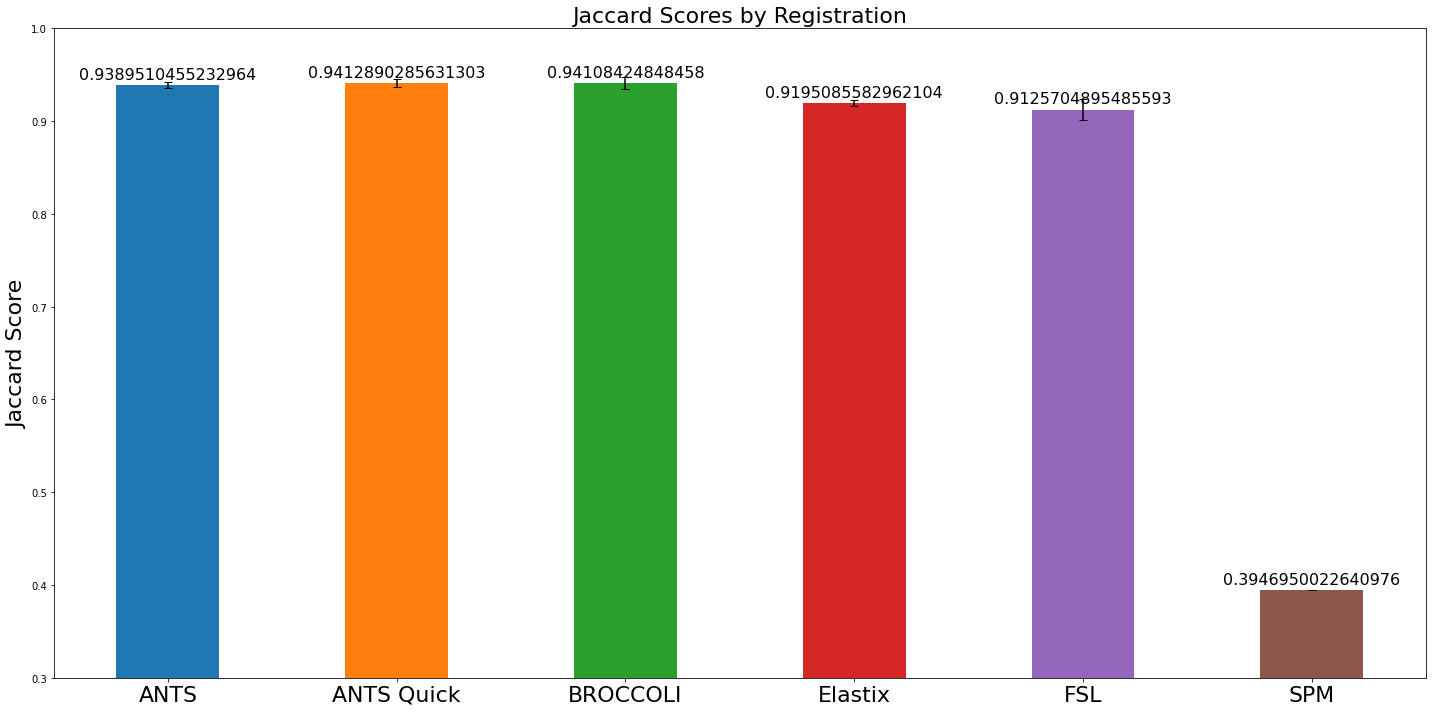

In [8]:
if __name__ == '__main__':
    registrationName = os.listdir(pipeline1)
    
    x = np.arange(len(registrationName)) 
    width = 0.45
    fig, ax = plt.subplots(figsize=(20, 10))
    
    for i in range(len(registrationName)):
        subjectJaccardScore = []
        print(f'Initializing jaccard on {registrationName[i]}')
        pool = Pool(os.cpu_count()-2)
        a = pool.map(jsFull_multi, subject)
        pool.close()
        pool.join()
        
        
        jsmean = np.mean(a)
        jsstd = np.std(a)
        
        subjectJaccardScore.append(registrationName[i])
        subjectJaccardScore.extend(a)
        subjectJaccardScore.extend([jsmean])
        subjectJaccardScore.extend([jsstd])
        title = np.vstack((title, subjectJaccardScore))
        rects = ax.bar(x[i], jsmean, width, label=f'{registrationName[i]}', yerr = jsstd, capsize=4)
        autolabel(rects)
    np.savetxt(p(f'{jSResultsFull}/JaccardScore.csv'), title, fmt='%s', delimiter = ',')
    
    ax.set_ylabel('Jaccard Score', fontname='Times New Roman', fontsize=22)
    ax.set_title('Jaccard Scores by Registration', fontname='Times New Roman', fontsize=22)
    ax.set_xticks(x)
    ax.set_xticklabels(registrationNameTag, fontname='Times New Roman', fontsize=22)
    
    fig.tight_layout()
    plt.ylim(0.3, 1)
    plt.savefig(p(f'{jSResultsFull}/JaccardScore.jpg'))

    plt.show()